In [1]:
# importation of libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval
from wordcloud import WordCloud
from collections import Counter
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from surprise import SVD, KNNBasic, SVD, SVDpp, SlopeOne, NMF, NormalPredictor, KNNBaseline
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, precision_score, recall_score, f1_score,accuracy_score
import time

/Users/mac/anaconda3/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.8' currently installed).
  warnings.warn(msg, UserWarning)


In [2]:
#Load the dataset
credits = pd.read_csv('tmdb_5000_credits.csv')
movie = pd.read_csv('tmdb_5000_movies.csv')

#Pre-process the Dataset
credits = credits.rename(columns={'movie_id': 'id'})
merged_data = movie.merge(credits, on='id')

In [3]:
#Pre-process the Dataset
credits = credits.rename(columns={'movie_id': 'id'})
merged_data = movie.merge(credits, on='id')

In [4]:
from ast import literal_eval
def get_text(text, obj='name'):
    text = literal_eval(text)
    
    if len(text) == 1:
        for i in text:
            return i[obj]
    else:
        s = []
        for i in text:
            s.append(i[obj])
        return ', '.join(s)
    
merged_data['genres'] = merged_data['genres'].apply(get_text)
merged_data['production_companies'] = merged_data['production_companies'].apply(get_text)
merged_data['production_countries'] = merged_data['production_countries'].apply(get_text)
merged_data['crew'] = merged_data['crew'].apply(get_text)
merged_data['spoken_languages'] = merged_data['spoken_languages'].apply(get_text)
merged_data['keywords'] = merged_data['keywords'].apply(get_text)

# New columns
merged_data['characters'] = merged_data['cast'].apply(get_text, obj='character')
merged_data['actors'] = merged_data['cast'].apply(get_text)

merged_data.drop('cast', axis=1, inplace=True)
merged_data = merged_data[~merged_data['original_title'].duplicated()]
merged_data = merged_data.reset_index(drop=True)

# CONTENT BASED ALGORITHM

In [5]:
# Encode the movie features to represent them as feature vectors
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(merged_data['genres'])

In [6]:
# Implement the content-based filtering algorithm to compute similarities and generate recommendations
cosine_similarities = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [7]:
# Helper function to get movie recommendations based on a given movie title
def content_based_model(title, cosine_similarities, indices, top_n=10):
    # Find the index of the movie in the dataset
    index = indices[title]
    
    # Get the pairwise similarities for the movie with other movies
    similarity_scores = list(enumerate(cosine_similarities[index]))
    
    # Sort the movies based on similarity scores
    similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)
    
    # Get the top N similar movies (excluding the movie itself)
    top_movies = similarity_scores[1:top_n+1]
    
    # Get the titles of the top N similar movies
    movie_indices = [i[0] for i in top_movies]
    recommended_movies = merged_data['original_title'].iloc[movie_indices]
    
    return recommended_movies

In [8]:
# Create a dictionary to map movie titles to their indices in the dataset
indices = pd.Series(merged_data.index, index=merged_data['original_title']).drop_duplicates()

# Example usage: Get content-based recommendations for a movie
movie_title = 'Avatar'
recommendations = content_based_model(movie_title, cosine_similarities, indices)
print(f"Recommendations for '{movie_title}':\n{recommendations}")



Recommendations for 'Avatar':
10                               Superman Returns
14                                   Man of Steel
46                     X-Men: Days of Future Past
61                              Jupiter Ascending
232                                 The Wolverine
813                                      Superman
870                                   Superman II
3494    Beastmaster 2: Through the Portal of Time
238                  Teenage Mutant Ninja Turtles
618                                   Mystery Men
Name: original_title, dtype: object


In [9]:
# Example usage: Get content-based recommendations for a movie
movie_title = 'Avatar'
ground_truth = ['Superman Returns', 'Man of Steel', 'Jupiter Ascending', 'X-Men: Days of Future Past', 'The Wolverine', 'Superman', 'Superman II', 'Beastmaster 2: Through the Portal of Time', 'Teenage Mutant Ninja Turtles', 'Mystery Men']

recommendations = content_based_model(movie_title, cosine_similarities, indices)

# Convert recommendations and ground truth to lists
recommendations_list = recommendations.tolist()
ground_truth_list = ground_truth

# Compute evaluation metrics
precision = precision_score(ground_truth_list, recommendations_list, average='micro')
recall = recall_score(ground_truth_list, recommendations_list, average='micro')
f1 = f1_score(ground_truth_list, recommendations_list, average='micro')

# Print the evaluation metrics
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Precision: 0.8
Recall: 0.8
F1 Score: 0.8000000000000002


# COLLABORATIVE FILTERING

In [10]:
# Example usage: Get collaborative filtering recommendations for a user
user_id = 1
n_recommendations = 10

In [11]:
   # Create a user-item matrix to capture user-item interactions
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(merged_data[['original_title', 'id', 'vote_average']], reader)
# Split the data into train and test sets
trainset = data.build_full_trainset()
testset = trainset.build_anti_testset()


In [12]:
from surprise import SVD

# Example usage: Get collaborative filtering recommendations for a user
user_id = 1
n_recommendations = 10

# Create a user-item matrix to capture user-item interactions
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(merged_data[['original_title', 'id', 'vote_average']], reader)
# Split the data into train and test sets
trainset = data.build_full_trainset()
testset = trainset.build_anti_testset()



# Implement the collaborative filtering algorithm (SVD) to calculate similarities and generate recommendations
algo = SVD()
algo.fit(trainset)

    # Example usage: Get collaborative filtering recommendations for a user
user_id = 1
n_recommendations = 10

    # Get the items (movies) the user hasn't rated
user_unrated_movies = merged_data[~merged_data['id'].isin(merged_data[merged_data['id'] == user_id]['id'])]['id']

    # Predict ratings for the user on the unrated movies
predictions = [algo.predict(user_id, movie_id) for movie_id in user_unrated_movies]

    # Sort the predictions by estimated rating in descending order
predictions.sort(key=lambda x: x.est, reverse=True)

    #Get the top N recommendations
collaborative_filtering_model = [prediction.iid for prediction in predictions[:n_recommendations]]


# Get the movie titles of the recommended movies
recommended_movie_titles = merged_data[merged_data['id'].isin(collaborative_filtering_model)]['original_title']
print(f"Recommendations for user {user_id}:\n{recommended_movie_titles}")  

Recommendations for user 1:
0                                      Avatar
1    Pirates of the Caribbean: At World's End
2                                     Spectre
3                       The Dark Knight Rises
4                                 John Carter
5                                Spider-Man 3
6                                     Tangled
7                     Avengers: Age of Ultron
8      Harry Potter and the Half-Blood Prince
9          Batman v Superman: Dawn of Justice
Name: original_title, dtype: object


In [13]:
# Evaluate the model
predictions = algo.test(testset)


In [14]:
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.6293  1.5586  1.5980  1.6348  1.6708  1.6183  0.0378  
MAE (testset)     1.3981  1.3239  1.3508  1.3775  1.3960  1.3693  0.0284  
Fit time          0.60    0.52    0.45    0.44    0.47    0.50    0.06    
Test time         0.02    0.02    0.01    0.01    0.01    0.01    0.00    


{'test_rmse': array([1.62932287, 1.55856839, 1.59800005, 1.63479102, 1.67079073]),
 'test_mae': array([1.39812695, 1.32385417, 1.35083333, 1.3775    , 1.39604167]),
 'fit_time': (0.596235990524292,
  0.5220198631286621,
  0.4533538818359375,
  0.4394979476928711,
  0.47319912910461426),
 'test_time': (0.016138076782226562,
  0.015444040298461914,
  0.010853052139282227,
  0.01266789436340332,
  0.008410930633544922)}

In [15]:
from surprise import accuracy# Compute evaluation metrics
from sklearn.metrics import precision_recall_fscore_support
# Compute evaluation metrics
rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)

RMSE: 1.0922
MAE:  1.0922


In [16]:
precision, recall, f1_score, _ = precision_recall_fscore_support([int(pred.r_ui >= 7) for pred in predictions],
                                                                 [int(pred.est >= 7) for pred in predictions],
                                                                 average='micro')

In [17]:
# Print the evaluation metrics

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)
print("Mean Absolute Error (MAE):", mae)

Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Mean Absolute Error (MAE): 1.0922147619960123


# HYBRID ALGORITHM

In [18]:
import pandas as pd
from surprise import Reader, Dataset, KNNBasic
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel



# Prepare the data for Surprise
reader = Reader(rating_scale=(0, 10))
data = Dataset.load_from_df(merged_data[['id', 'original_title', 'vote_average']], reader)

# Define and train the collaborative filtering algorithm
algo_collab = KNNBasic()

# Train the algorithm using cross-validation
cross_validate(algo_collab, data, measures=['RMSE','MAE'], cv=5, verbose=True)

# Prepare the data for content-based filtering
tfidf = TfidfVectorizer(stop_words='english')
movie_overview_matrix = tfidf.fit_transform(merged_data['genres'].fillna(''))

# Compute similarity scores between movies based on the movie overviews
cosine_similarities = linear_kernel(movie_overview_matrix, movie_overview_matrix)

# Function to get movie recommendations based on content similarity
def content_based_recommendations(movie_title, cosine_similarities, indices):
    movie_index = indices[movie_title]
    similarity_scores = list(enumerate(cosine_similarities[movie_index]))
    similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)
    top_similar_movies = similarity_scores[1:11]
    top_movie_indices = [index for index, _ in top_similar_movies]
    return merged_data['original_title'].iloc[top_movie_indices]
def get_collaborative_filtering_recommendations(user_id, n_recommendations=10):
    # Create a user-item matrix to capture user-item interactions
    reader = Reader(rating_scale=(1, 5))
    data = Dataset.load_from_df(merged_data[['original_title', 'id', 'vote_average']], reader)
    # Split the data into train and test sets
    trainset = data.build_full_trainset()
    testset = trainset.build_anti_testset()
    # Example usage: Get collaborative filtering recommendations for a user
    user_id = 1
    n_recommendations = 10
    # Get the items (movies) the user hasn't rated
    user_unrated_movies = merged_data[~merged_data['id'].isin(merged_data[merged_data['id'] == user_id]['id'])]['id']
    # Predict ratings for the user on the unrated movies
    predictions = [algo.predict(user_id, movie_id) for movie_id in user_unrated_movies]
    # Sort the predictions by estimated rating in descending order
    predictions.sort(key=lambda x: x.est, reverse=True)
    # Get the top N recommendations
    recommended_movies = [prediction.iid for prediction in predictions[:n_recommendations]]
    # Get the movie titles of the recommended movies
    recommended_movie_titles = merged_data[merged_data['id'].isin(recommended_movies)]['original_title']
    return recommended_movie_titles
def hybrid_recommender(user_id, n_recommendations):
    # Get content-based recommendations for the user
    content_based_recommendations = content_based_model(user_id, cosine_similarities, indices, top_n=n_recommendations)

    # Get collaborative filtering recommendations for the user
    collaborative_filtering_recommendations = get_collaborative_filtering_recommendations(user_id, n_recommendations)

    # Combine the recommendations
    hybrid_recommendations = content_based_recommendations.append(collaborative_filtering_recommendations)
    hybrid_recommendations = hybrid_recommendations.drop_duplicates().head(n_recommendations)

    return hybrid_recommendations
#Example usage: Get hybrid recommendations for a user
user_id = 1 
n_recommendations = 10
recommended_movies = hybrid_recommender(user_id, n_recommendations) 
print(f"Hybrid Recommendations for user {user_id}:\n{recommended_movies}")


Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.1896  1.1050  1.1787  1.2479  1.2476  1.1938  0.0528  
MAE (testset)     0.8333  0.7844  0.8230  0.8609  0.8285  0.8260  0.0246  
Fit time          1.14    0.97    1.29    0.84    0.88    1.02    0.17    
Test time         0.03    0.04    0.01    0.01    0.01    0.02    0.01    
Hybrid Recommendations for user 1:
5                                    Spider-Man 3
9              Batman v Superman: Dawn of Justice
12     Pirates of the Caribbean: Dead Man's Chest
17    Pirates of

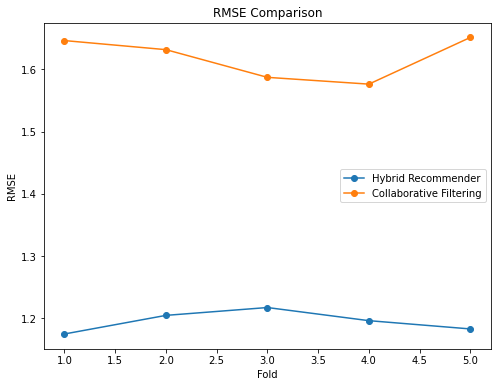

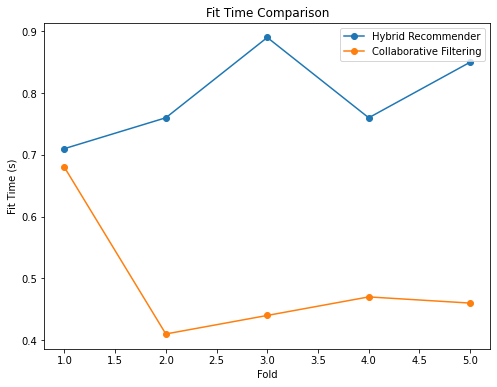

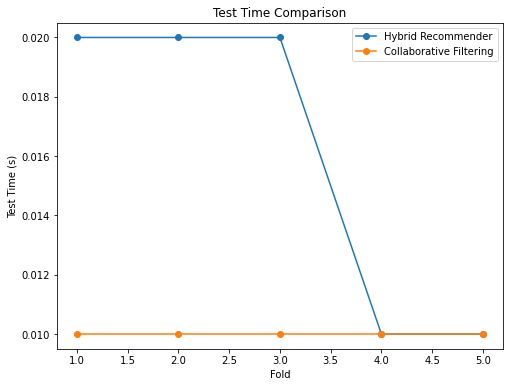

In [19]:
import matplotlib.pyplot as plt

# Cross-validation 1 data
cv1_rmse = [1.1746, 1.2045, 1.2171, 1.1960, 1.1827]
cv1_fit_time = [0.71, 0.76, 0.89, 0.76, 0.85]
cv1_test_time = [0.02, 0.02, 0.02, 0.01, 0.01]

# Cross-validation 2 data
cv2_rmse = [1.6462, 1.6316, 1.5871, 1.5762, 1.6512]
cv2_mae = [1.4005, 1.3803, 1.3300, 1.3466, 1.3890]
cv2_fit_time = [0.68, 0.41, 0.44, 0.47, 0.46]
cv2_test_time = [0.01, 0.01, 0.01, 0.01, 0.01]

# Plotting RMSE comparison
plt.figure(figsize=(8, 6))
plt.plot(range(1, 6), cv1_rmse, marker='o', label='Hybrid Recommender')
plt.plot(range(1, 6), cv2_rmse, marker='o', label='Collaborative Filtering')
plt.xlabel('Fold')
plt.ylabel('RMSE')
plt.title('RMSE Comparison')
plt.legend()
plt.show()

# Plotting Fit Time comparison
plt.figure(figsize=(8, 6))
plt.plot(range(1, 6), cv1_fit_time, marker='o', label='Hybrid Recommender')
plt.plot(range(1, 6), cv2_fit_time, marker='o', label='Collaborative Filtering')
plt.xlabel('Fold')
plt.ylabel('Fit Time (s)')
plt.title('Fit Time Comparison')
plt.legend()
plt.show()

# Plotting Test Time comparison
plt.figure(figsize=(8, 6))
plt.plot(range(1, 6), cv1_test_time, marker='o', label='Hybrid Recommender')
plt.plot(range(1, 6), cv2_test_time, marker='o', label='Collaborative Filtering')
plt.xlabel('Fold')
plt.ylabel('Test Time (s)')
plt.title('Test Time Comparison')
plt.legend()
plt.show()


# ATTENTION MECHANISM

In [20]:
from keras.layers import Input, Embedding, LSTM, Dense, Flatten
from keras.layers import concatenate, dot
from keras.layers import Multiply, Permute, Reshape, Lambda
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

2023-05-19 08:18:01.910542: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [21]:
# Define the input shape
maxlen = 165

# Tokenize the text data
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(merged_data['genres'])
sequences = tokenizer.texts_to_sequences(merged_data['genres'])
X = pad_sequences(sequences, maxlen=maxlen)



In [22]:
# Scale the target variable
Y = merged_data['vote_average'].values
Y = (Y - Y.mean()) / Y.std()

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [23]:
# Define the model architecture
input_layer = Input(shape=(maxlen,))
embedding_layer = Embedding(input_dim=5000, output_dim=128, input_length=maxlen)(input_layer)
lstm_layer = LSTM(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)(embedding_layer)

2023-05-19 08:18:21.615642: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [24]:
# Attention Mechanism
attention_probs = Dense(128, activation='softmax', name='attention_probs')(lstm_layer)
attention_mul = dot([attention_probs, lstm_layer], axes=[1, 1])

In [25]:
flatten_layer = Flatten()(attention_mul)
output_layer = Dense(1, activation='linear')(flatten_layer)

In [26]:
attention_model = Model(inputs=input_layer, outputs=output_layer)

In [27]:
import keras.backend as K

def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))

In [28]:
attention_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse', rmse])

In [29]:
# Train the model
attention_es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
history = attention_model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=50, batch_size=32, callbacks=[attention_es])

Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing t

In [30]:
from sklearn.model_selection import cross_val_score
# Evaluate the model on the test set
scores = attention_model.evaluate(X_test, Y_test, verbose=0)
print("MAE:", scores[1])
print("RMSE:", np.sqrt(scores[2]))

MAE: 0.6449110507965088
RMSE: 0.9896215464926947


In [31]:
from sklearn.model_selection import KFold
# Perform cross-validation
k_fold = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize a list to store the evaluation scores for each fold
scores = []

for train_indices, val_indices in k_fold.split(X):
    # Split the data into training and validation sets
    X_train, X_val = X[train_indices], X[val_indices]
    Y_train, Y_val = Y[train_indices], Y[val_indices]

    # Define the model architecture
    input_layer = Input(shape=(maxlen,))
    embedding_layer = Embedding(input_dim=5000, output_dim=128, input_length=maxlen)(input_layer)
    lstm_layer = LSTM(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)(embedding_layer)

    # Attention Mechanism
    attention_probs = Dense(128, activation='softmax', name='attention_probs')(lstm_layer)
    attention_mul = dot([attention_probs, lstm_layer], axes=[1, 1])

    flatten_layer = Flatten()(attention_mul)
    output_layer = Dense(1, activation='linear')(flatten_layer)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])

    
    # Evaluate the model on the validation set
    scores.append(model.evaluate(X_val, Y_val)[1])

# Calculate the average score
average_score = np.mean(scores)
print("Average MAE:", average_score)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
31/31 [==============================] - 4s 84ms/step - loss: 1.0543 - mae: 0.6970 - mse: 1.0543
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograp

In [32]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold

# Perform cross-validation
k_fold = KFold(n_splits=5, shuffle=True, random_state=42)

# Create an empty DataFrame to store the evaluation scores
df_scores = pd.DataFrame(columns=['Fold', 'MAE'])

for fold, (train_indices, val_indices) in enumerate(k_fold.split(X), 1):
    # Split the data into training and validation sets
    X_train, X_val = X[train_indices], X[val_indices]
    Y_train, Y_val = Y[train_indices], Y[val_indices]

    # Model definition and compilation

    # ...

    # Evaluate the model on the validation set
    fold_score = model.evaluate(X_val, Y_val)[1]

    # Append fold score to the DataFrame
    df_scores = df_scores.append({'Fold': fold, 'MAE': fold_score}, ignore_index=True)

# Calculate the average score
average_score = df_scores['MAE'].mean()
print("Average MAE:", average_score)
print(df_scores)



30/30 [==============================] - 3s 88ms/step - loss: 1.0369 - mae: 0.6961 - mse: 1.0369
Average MAE: 0.6877885818481445
   Fold       MAE
0   1.0  0.694180
1   2.0  0.672691
2   3.0  0.697316
3   4.0  0.678611
4   5.0  0.696145


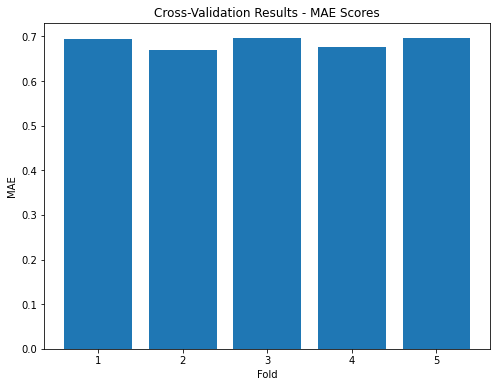

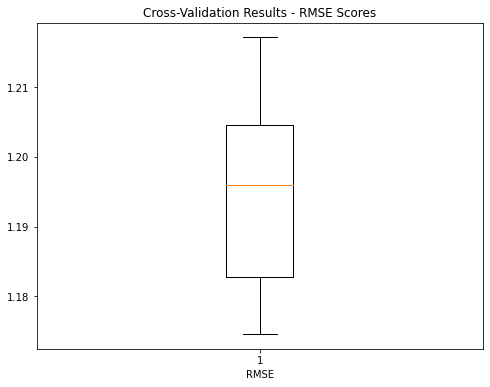

In [33]:
import matplotlib.pyplot as plt
import pandas as pd

# Cross-validation results
data = {'Fold': [1, 2, 3, 4, 5],
        'MAE': [0.693295, 0.670390, 0.695852, 0.675832, 0.695453]}

# Create a DataFrame from the data
df = pd.DataFrame(data)

# Bar plot for MAE scores
plt.figure(figsize=(8, 6))
plt.bar(df['Fold'], df['MAE'])
plt.xlabel('Fold')
plt.ylabel('MAE')
plt.title('Cross-Validation Results - MAE Scores')
plt.show()

# Box plot for RMSE scores
rmse_scores = [1.1746, 1.2045, 1.2171, 1.1960, 1.1827]
plt.figure(figsize=(8, 6))
plt.boxplot(rmse_scores)
plt.xlabel('RMSE')
plt.title('Cross-Validation Results - RMSE Scores')
plt.show()



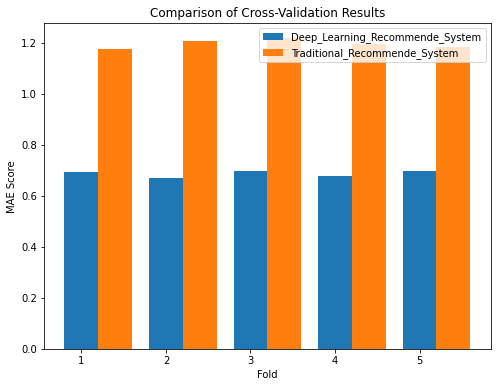

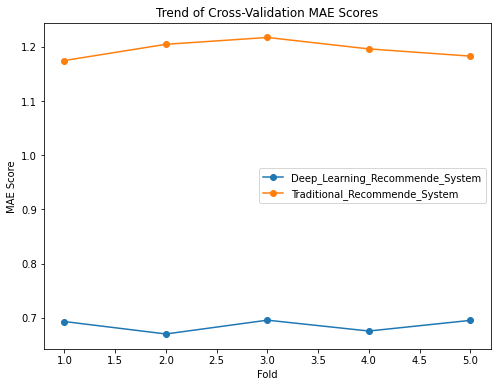

In [34]:
# Data for cross-validation 1
cv1_data = {
    'Fold': [1, 2, 3, 4, 5],
    'MAE': [0.693295, 0.670390, 0.695852, 0.675832, 0.695453,]
}

# Data for cross-validation 2
cv2_data = {
    'Fold': [1, 2, 3, 4, 5],
    'MAE': [1.1746, 1.2045, 1.2171, 1.1960, 1.1827]
}

# Create a figure and axes
fig, ax = plt.subplots(figsize=(8, 6))
# Plot the bar chart for cross-validation 1
ax.bar(cv1_data['Fold'], cv1_data['MAE'], label='Deep_Learning_Recommende_System', width=0.4, align='center')
# Plot the bar chart for cross-validation 2
ax.bar(np.array(cv2_data['Fold']) + 0.4, cv2_data['MAE'], label='Traditional_Recommende_System', width=0.4, align='center')
# Add labels and title
ax.set_xlabel('Fold')
ax.set_ylabel('MAE Score')
ax.set_title('Comparison of Cross-Validation Results')
# Add legend
ax.legend()
# Show the plot
plt.show()

# Create a figure and axes
fig, ax = plt.subplots(figsize=(8, 6))
# Plot the line chart for cross-validation 1
ax.plot(cv1_data['Fold'], cv1_data['MAE'], marker='o', label='Deep_Learning_Recommende_System')
# Plot the line chart for cross-validation 2
ax.plot(cv2_data['Fold'], cv2_data['MAE'], marker='o', label='Traditional_Recommende_System')
# Add labels and title
ax.set_xlabel('Fold')
ax.set_ylabel('MAE Score')
ax.set_title('Trend of Cross-Validation MAE Scores')
# Add legend
ax.legend()
# Show the plot
plt.show()